In [74]:
%%script true

!pip install catboost optuna utm

from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/black-cat'

In [75]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel

from scipy.spatial.distance import cdist
import geopandas as gpd
from shapely.geometry import Point
import utm

from catboost import CatBoostClassifier, EFeaturesSelectionAlgorithm
import catboost as cb
from catboost.utils import Pool
from xgboost import XGBClassifier
from xgboost import plot_importance
import optuna


%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.style.use('ggplot')


# # Create your connection.
# import sqlite3
# con = sqlite3.connect('files/firedata.sqlite')
# res = con.execute("SELECT name FROM sqlite_master WHERE type='table';")
# fires_df = pd.read_sql_query("SELECT * FROM Fires", con)
# agency = pd.read_sql_query("SELECT * FROM NWCG_UnitIDActive_20170109", con)
# con.close()

fires_df = pd.read_csv('datasets/wildfires.csv')

In [76]:
CLIMATE_REGIONS = {
    "northwest": ["WA", "OR", "ID"],
    "west": ["CA", "NV"],
    "southwest": ["UT", "CO", "AZ", "NM"],
    "northern_rockies": ["MT", "ND", "SD", "WY", "NE"],
    "upper_midwest": ["KS", "OK", "TX", "AR", "LA", "MS"],
    "south": ["MN", "WI", "MI", "IA"],
    "ohio_valley": ["MO", "IL", "IN", "OH", "WV", "KY", "TN"],
    "southeast": ["VA", "NC", "SC", "GA", "AL", "FL"],
    "northeast": ["ME", "NH", "VT", "NY", "PA", "MA", "RI", "CT", "NJ", "DE", "MD", "DC"],
    "alaska": [
        "AK",
    ],
    "hawaii": ["HI"],
    "puerto_rico": ["PR"],
}

MOST_COMMON_IDS = ["USGAGAS", "USTXTXS", "USNCNCS", "USFLFLS", "USNYNYX", "USMSMSS", "USALALS", "USSCSCS"]

STATE_MAP = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "District of Columbia": "DC",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Puerto Rico": "PR",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "Virgin Islands": "other",
    "Guam": "other",
    "Nationwide (States, DC, and Territories)": "other",
    "Nationwide (States and DC)": "other",
}


def plot_metrics(model, X_test, y_test, label_encoder=None):
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)
    if label_encoder is not None:
        y_test_labeled = pd.Series(label_encoder.inverse_transform(y_test))
        labels = label_encoder.classes_
    else:
        labels = y_test.unique()
    _, axs = plt.subplots(1, 2, figsize=(20, 8))

    auc_score = roc_auc_score(y_test, y_probs, multi_class="ovr", average="weighted")
    y_test_bin = LabelBinarizer().fit_transform(y_test)
    for class_id in range(len(labels)):
        RocCurveDisplay.from_predictions(
            y_test_bin[:, class_id],
            y_probs[:, class_id],
            name=f"ROC curve for {labels[class_id]}",
            ax=axs[0],
        )
    axs[0].set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="ROC Curve (AUC = {:.3f})".format(auc_score),
    )

    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cmap="Blues", ax=axs[1], fmt=".2f")
    axs[1].set_title("Confusion Matrix")
    axs[1].set_ylabel("True Label")
    axs[1].set_xlabel("Predicted Label")
    plt.show()

## Pre-Process

In [77]:
# fires_df = fires_df.head(100000)
fires_df.drop(
    columns=[
        "FPA_ID",
        "SOURCE_SYSTEM",
        "NWCG_REPORTING_AGENCY",
        "OBJECTID",
        "FOD_ID",
        "LOCAL_FIRE_REPORT_ID",
        "FIRE_CODE",
        "ICS_209_INCIDENT_NUMBER",
        "ICS_209_NAME",
        "MTBS_ID",
        "MTBS_FIRE_NAME",
        "COMPLEX_NAME",
        "LOCAL_INCIDENT_ID",
        "COUNTY",
        "Shape",
    ],
    inplace=True,
)

train, test = train_test_split(fires_df, test_size=0.2, random_state=42)
train.drop(train[train["CONT_DATE"] - train["DISCOVERY_DATE"] > 120].index, inplace=True)
train.dropna(subset=["STAT_CAUSE_DESCR", "LATITUDE", "LONGITUDE"], inplace=True)

### Date and Time

In [78]:
def time_change(data):
    def split_time(time):
        if pd.isnull(time):
            return pd.NA
        else:
            time_str = str(time).zfill(4)  # Ensure time is represented as 4 digits
            return int(float(time_str) // 100)

    data["DISCOVERY_HOUR"] = data["DISCOVERY_TIME"].apply(lambda x: split_time(x))
    data["CONT_HOUR"] = data["CONT_TIME"].apply(lambda x: split_time(x))
    return data

def fill_missing_datetime(train, test):
    missing_features = ["DISCOVERY_HOUR", "CONT_DATE", "CONT_HOUR"]
    model_features = ["DISCOVERY_DATE", "FIRE_SIZE", "LATITUDE", "LONGITUDE"]

    for feature in missing_features:
        not_null_train = train.loc[train[feature].notnull(), model_features + [feature]]
        null_train = train.loc[train[feature].isnull(), model_features]
        model = RandomForestRegressor(n_estimators=10)
        model.fit(not_null_train[model_features], not_null_train[feature])
        train.loc[null_train.index, feature] = model.predict(null_train[model_features])

        null_test = test.loc[test[feature].isnull(), model_features]
        test.loc[null_test.index, feature] = model.predict(null_test[model_features])

    return train, test

train = time_change(train)
test = time_change(test)
train, test = fill_missing_datetime(train, test)

In [79]:
def date_preprocess(data):
    data.loc[data["CONT_DATE"] < data["DISCOVERY_DATE"], "CONT_DATE"] = data.loc[
        data["CONT_DATE"] < data["DISCOVERY_DATE"], "DISCOVERY_DATE"
    ]
    data["CONT_DATE"] = data["CONT_DATE"].apply(lambda x: round(x * 2) / 2)
    data["CONT_DOY"] = pd.to_datetime(data["CONT_DATE"], unit="D", origin="julian").dt.dayofyear
    data = data.round({"DISCOVERY_HOUR": 0, "CONT_HOUR": 0})
    data["FIRE_YEAR"] = pd.to_datetime(data["FIRE_YEAR"], format="%Y").dt.year
    return data


train = date_preprocess(train)
test = date_preprocess(test)

### Locatoion

FIPS code fill mising and formatting

In [80]:
# %%script true

def fill_fips_code(data, state_county_df):
    state_county_df["fips_code"] = state_county_df["fips_code"].astype(str).str.zfill(5)
    state_county_df["county_code"] = state_county_df["fips_code"].str[-3:]
    fips_by_state_county = state_county_df.groupby(["state", "county_code"])["fips_code"]
    data_fips = data["FIPS_CODE"].convert_dtypes().astype(str)

    # Fill in known FIPS codes
    for i, code in enumerate(zip(data["STATE"], data_fips.str.zfill(3))):
        if code in fips_by_state_county.groups:
            data_fips.iloc[i] = fips_by_state_county.get_group(code).iloc[0]

    # Fill in missing FIPS codes
    for i, row in data.loc[data["FIPS_CODE"].isnull()].iterrows():
        state = row["STATE"]
        lat, lng = row["LATITUDE"], row["LONGITUDE"]
        state_counties = state_county_df[state_county_df["state"] == state]
        closest_county_idx = cdist([[lat, lng]], state_counties[["lat", "long"]], "euclidean").argmin()
        data_fips[i] = state_counties.iloc[closest_county_idx]["fips_code"]

    data["FIPS_CODE"] = data_fips.astype(str)
    return data

state_county_df = pd.read_csv("datasets/state_county_long_lat.csv")
train = fill_fips_code(train, state_county_df)
test = fill_fips_code(test, state_county_df)

In [81]:
def location_preprocess(data):
    data["OWNER_CODE"] = data["OWNER_CODE"].convert_dtypes().astype(str)
    return data

train = location_preprocess(train)
test = location_preprocess(test)

## Feature Engineering

### Date and Time

In [82]:
def new_datetime_features(data):
    data["DISCOVERY_DATE_FORMATED"] = pd.to_datetime(data["DISCOVERY_DATE"], unit="D", origin="julian")
    data["FIRE_MONTH"] = pd.to_datetime(data["DISCOVERY_DATE"], unit="D", origin="julian").dt.month
    data["FIRE_WEEK"] = pd.to_datetime(data["DISCOVERY_DATE"], unit="D", origin="julian").dt.isocalendar().week
    data["DISCOVERY_DOW"] = pd.to_datetime(data["DISCOVERY_DATE"], unit="D", origin="julian").dt.dayofweek
    data["DISCOVERY_DOM"] = pd.to_datetime(data["DISCOVERY_DATE"], unit="D", origin="julian").dt.day
    data["DISCOVERY_IS_WKND"] = data["DISCOVERY_DOW"] > 4
    data["DISCOVERY_IS_SUMMER"] = (data["DISCOVERY_DOY"] >= 153) & (data["DISCOVERY_DOY"] < 245)
    data["CONT_DOW"] = pd.to_datetime(data["CONT_DATE"], unit="D", origin="julian").dt.dayofweek
    data["DISCOVERY_DATETIME"] = pd.to_datetime(data["DISCOVERY_DATE"], unit="D", origin="julian") + pd.to_timedelta(
        data["DISCOVERY_HOUR"], unit="h"
    )
    data["CONT_DATETIME"] = pd.to_datetime(data["CONT_DATE"], unit="D", origin="julian") + pd.to_timedelta(data["CONT_HOUR"], unit="h")
    data["FIRE_DUR_DAYS"] = (data["CONT_DATETIME"] - data["DISCOVERY_DATETIME"]).dt.days + 1
    data["FIRE_DUR_HOURS"] = (data["CONT_DATETIME"] - data["DISCOVERY_DATETIME"]).dt.seconds / 3600
    data["4TH_JULY"] = data["DISCOVERY_DOY"].isin([185, 186])
    data["DISCOVERY_NOON"] = data["DISCOVERY_HOUR"].apply(lambda x: 1 if x in [11, 12, 17, 18] else 2 if x in [13, 14, 15, 16] else 0)
    data["MONTH_SIN"] = np.sin(2 * np.pi * data["FIRE_MONTH"] / 12)
    data["MONTH_COS"] = np.cos(2 * np.pi * data["FIRE_MONTH"] / 12)
    data["DAY_OF_WEEK_SIN"] = np.sin(2 * np.pi * data["DISCOVERY_DOW"] / 7)
    data["DAY_OF_WEEK_COS"] = np.cos(2 * np.pi * data["DISCOVERY_DOW"] / 7)
    data["DAY_OF_YEAR_SIN"] = np.sin(2 * np.pi * data["DISCOVERY_DOY"] / 365)
    data["DAY_OF_YEAR_COS"] = np.cos(2 * np.pi * data["DISCOVERY_DOY"] / 365)
    return data


train = new_datetime_features(train)
test = new_datetime_features(test)

In [83]:
def climate_region(data):
    state_region_mapping = {}
    for region, region_states in CLIMATE_REGIONS.items():
        for state in region_states:
            state_region_mapping[state] = region
    return data["STATE"].apply(lambda x: state_region_mapping[x]).astype(str)

def categorize_unit_id(unit_id):
    if unit_id in MOST_COMMON_IDS:
        return unit_id
    else:
        return "other"

def categorize_fire_size_class(fire_class):
    if fire_class in ["A", "B", "C"]:
        return fire_class
    else:
        return "D"


def new_location_features(data):
    data["NWCG_REPORTING_UNIT_ID"] = data["NWCG_REPORTING_UNIT_ID"].apply(categorize_unit_id)
    data["NEAR_FOREST"] = data["NWCG_REPORTING_UNIT_NAME"].str.contains("forest", case=False)
    data["OWNER_GROUP"] = data["OWNER_CODE"].apply(lambda x: 1 if x==5 else 2 if x==8 else 3 if x==14 else 0)
    data["CLIMATE_REGION"] = climate_region(data)
    data["FIRE_SIZE_CLASS"] = data["FIRE_SIZE_CLASS"].apply(categorize_fire_size_class)
    return data


train = new_location_features(train)
test = new_location_features(test)

In [84]:
train['geometry'] = [Point(lon, lat) for lon, lat in zip(train['LONGITUDE'], train['LATITUDE'])]
gdf_train = gpd.GeoDataFrame(train, geometry='geometry')
county_centroids_train = gdf_train.groupby('FIPS_CODE')['geometry'].apply(lambda x: x.unary_union.centroid).reset_index()
county_centroids_train.columns = ['FIPS_CODE', 'county_centroid']
train = pd.merge(train, county_centroids_train, on='FIPS_CODE')

# Calculate the distance from each fire to the centroid of its state
train['distance_to_county_centroid'] = train.apply(lambda row: row['geometry'].distance(row['county_centroid']), axis=1)

# Use centroids calculated from X_train to calculate distances for X_test
test['geometry'] = [Point(lon, lat) for lon, lat in zip(test['LONGITUDE'], test['LATITUDE'])]
gdf_test = gpd.GeoDataFrame(test, geometry='geometry')
test = pd.merge(test, county_centroids_train, on='FIPS_CODE')

# Calculate the distance from each fire in X_test to the centroid of its state (based on X_train centroids)
test['distance_to_county_centroid'] = test.apply(lambda row: row['geometry'].distance(row['county_centroid']), axis=1)

In [85]:
def create_easting_northing(data):
    def convert(lat, lng):
        easting, northing, _, _ = utm.from_latlon(lat, lng)
        return easting, northing

    # Apply the conversion function to each row of the DataFrame
    data[['easting', 'northing']] = data.apply(lambda row: pd.Series(convert(row['LATITUDE'], row['LONGITUDE'])), axis=1)

    return data

train = create_easting_northing(train)
test = create_easting_northing(test)

### Weather

In [86]:
temperatures_df = pd.read_csv("datasets/temperatures.csv")

# Step 2: Map the full state names in temperatures_df to their corresponding abbreviations
temperatures_df["State_Abbreviation"] = temperatures_df["State"].map(STATE_MAP)
temperatures_df["AvgTemperature_State_Year_Month"] = temperatures_df.groupby(["State_Abbreviation", "Year", "Month"])[
    "AvgTemperature"
].transform("mean")
grouped_temps = temperatures_df.groupby(["State_Abbreviation", "Year", "Month"])["AvgTemperature_State_Year_Month"].mean().reset_index()

# Merge the grouped temperatures with train on state, year, and month
merged_train = pd.merge(
    train, grouped_temps, how="left", left_on=["STATE", "FIRE_YEAR", "FIRE_MONTH"], right_on=["State_Abbreviation", "Year", "Month"]
)

# Drop redundant columns
merged_train.drop(columns=["State_Abbreviation", "Year", "Month"], inplace=True)

# Rename the merged column
merged_train.rename(columns={"AvgTemperature_State_Year_Month": "AvgTemperature_State_Year_Month"}, inplace=True)

subset_1995 = merged_train[(merged_train["FIRE_YEAR"] == 1995)]

# Group the subset by state and month and calculate the mean temperature for each group
mean_temps_1995 = subset_1995.groupby(["STATE", "FIRE_MONTH"])["AvgTemperature_State_Year_Month"].mean().reset_index()

# Merge the mean temperatures with the original merged_train based on state and month
final_merged_train = pd.merge(merged_train, mean_temps_1995, how="left", on=["STATE", "FIRE_MONTH"], suffixes=("", "_1995"))

# Fill NaN values in the AvgTemperature_State_Year_Month column with corresponding values from 2015
final_merged_train["AvgTemperature_State_Year_Month"].fillna(final_merged_train["AvgTemperature_State_Year_Month_1995"], inplace=True)

# Drop the redundant column
final_merged_train.drop(columns=["AvgTemperature_State_Year_Month_1995"], inplace=True)

mean_temps = final_merged_train.groupby(["STATE", "FIRE_YEAR", "FIRE_MONTH"])["AvgTemperature_State_Year_Month"].mean().reset_index()

In [87]:
# Merge the mean temperatures with the original train DataFrame based on STATE, FIRE_YEAR, and FIRE_MONTH
train = pd.merge(train, mean_temps, how="left", on=["STATE", "FIRE_YEAR", "FIRE_MONTH"])
#####TESTTTTTTTTTTTTTTTTTTTT
test = pd.merge(test, mean_temps, how="left", on=["STATE", "FIRE_YEAR", "FIRE_MONTH"])

train["AvgTemperature_in_celsius"] = train["AvgTemperature_State_Year_Month"].map(lambda x: x - 32 if x > 0 else x + 32)  # Celsius
test["AvgTemperature_in_celsius"] = test["AvgTemperature_State_Year_Month"].map(lambda x: x - 32 if x > 0 else x + 32)  # Celsius
train["Temperature_Deviation"] = train["AvgTemperature_in_celsius"] - train["AvgTemperature_in_celsius"].mean()
test["Temperature_Deviation"] = test["AvgTemperature_in_celsius"] - test["AvgTemperature_in_celsius"].mean()

### Smoking

In [88]:
def fill_missing_year(smoking_df, state, year):
    following_year = year + 1
    exist_row_following_year = smoking_df[(smoking_df["State"] == state) & (smoking_df["Year"] == following_year)]

    # Create a copy of the existing row
    copy_row = exist_row_following_year.copy()
    copy_row["Year"] = year  # Update the year in the copied row

    # Append the copied row to the DataFrame
    smoking_df = pd.concat([smoking_df, copy_row], ignore_index=True)

    return smoking_df


smoking_df = pd.read_csv("datasets/tobacco.csv")
smoking_df = fill_missing_year(smoking_df, "District of Columbia", 1995)
smoking_df = fill_missing_year(smoking_df, "Hawaii", 2004)
smoking_df = fill_missing_year(smoking_df, "Puerto Rico", 1995)
smoking_df = fill_missing_year(smoking_df, "Utah", 1996)
smoking_df = fill_missing_year(smoking_df, "Utah", 1995)

# Step 2: Map the full state names in temperatures_df to their corresponding abbreviations
smoking_df["State_Abbreviation"] = smoking_df["State"].map(STATE_MAP)

In [89]:
smoking_df["Smoke everyday"] = smoking_df["Smoke everyday"].str.rstrip("%").astype("float")
smoking_df["Smoke some days"] = smoking_df["Smoke some days"].str.rstrip("%").astype("float")
smoking_df["smokers_percentage"] = smoking_df["Smoke everyday"] + smoking_df["Smoke some days"]

# Group by year and state, calculate the mean smoking rate for each group
smoking_df["avg_smoking_rate"] = smoking_df.groupby(["Year", "State"])["smokers_percentage"].transform("mean")

# Calculate the 33% and 66% quantiles for each year
quantile_33 = smoking_df.groupby("Year")["avg_smoking_rate"].quantile(0.33)
quantile_66 = smoking_df.groupby("Year")["avg_smoking_rate"].quantile(0.66)


# Function to assign smoking category based on quantiles
def assign_category(avg_rate, quantile_33, quantile_66):
    if avg_rate <= quantile_33:
        return -1
    elif avg_rate <= quantile_66:
        return 0
    else:
        return 1


# Create a new column for smoking category
smoking_df["smoking_category"] = smoking_df.apply(
    lambda x: assign_category(x["avg_smoking_rate"], quantile_33[x["Year"]], quantile_66[x["Year"]]), axis=1
)


def merge_smoking_df(df, smoking_df):

    grouped_smoking = smoking_df.groupby(["State_Abbreviation", "Year"])["avg_smoking_rate"].mean().reset_index()

    # Merge the grouped temperatures with train on state, year, and month
    df = pd.merge(df, grouped_smoking, how="left", left_on=["STATE", "FIRE_YEAR"], right_on=["State_Abbreviation", "Year"])

    # Drop redundant columns
    df.drop(columns=["State_Abbreviation", "Year"], inplace=True)

    # Rename the merged column
    df.rename(columns={"avg_smoking_rate": "avg_smoking_rate"}, inplace=True)
    return df


train = merge_smoking_df(train, smoking_df)
test = merge_smoking_df(test, smoking_df)

In [90]:
years_of_interest = [1995, 1996, 1997, 2008, 2009, 2010]

# Initialize the dictionary to store average smoking rates
state_year_avg_smoking_rate = {}

# Iterate over the years and states to calculate and store average smoking rates
for year in years_of_interest:
    # Filter smoking_df for the current year
    year_data = smoking_df[smoking_df["Year"] == year]

    # Iterate over the states in the current year
    for state, avg_smoking_rate in zip(year_data["State_Abbreviation"], year_data["avg_smoking_rate"]):
        # Create a tuple of state and year as the key
        key = (state, year)

        # Add the avg_smoking_rate to the dictionary
        state_year_avg_smoking_rate[key] = avg_smoking_rate


for year in range(2011, 2016):
    for state in smoking_df["State_Abbreviation"].unique():
        mean_smoking_rate = 0
        for before_year in range(year - 3, year):
            key = (state, before_year)
            value = state_year_avg_smoking_rate[key]
            mean_smoking_rate += value
        mean_smoking_rate /= 3
        new_key = (state, year)
        state_year_avg_smoking_rate[new_key] = mean_smoking_rate

for year in range(1994, 1991, -1):
    for state in smoking_df["State_Abbreviation"].unique():
        if state != "other":
            mean_smoking_rate = 0
            for before_year in range(year + 1, year + 4):
                key = (state, before_year)
                value = state_year_avg_smoking_rate[key]
                mean_smoking_rate += value
            mean_smoking_rate /= 3
            new_key = (state, year)
            state_year_avg_smoking_rate[new_key] = mean_smoking_rate


def fill_missing_avg_smoking_rate(row, state_year_avg_smoking_rate):
    state = row["STATE"]
    year = row["FIRE_YEAR"]
    if pd.isnull(row["avg_smoking_rate"]) and (state, year) in state_year_avg_smoking_rate:
        return state_year_avg_smoking_rate[(state, year)]
    else:
        return row["avg_smoking_rate"]


# Apply the function to fill missing values
train["avg_smoking_rate"] = train.apply(fill_missing_avg_smoking_rate, args=(state_year_avg_smoking_rate,), axis=1)
test["avg_smoking_rate"] = test.apply(fill_missing_avg_smoking_rate, args=(state_year_avg_smoking_rate,), axis=1)

In [91]:
# Read the population data
population_df = pd.read_csv("datasets/population.csv")

# Compute population_by_year_state only once
population_by_year_state = population_df.groupby(["year", "state"])["population"].sum().reset_index()
population_by_year_state.to_csv("datasets/population_by_year_state.csv", index=False)

### Population

In [92]:
def population_feature(data, population_by_year_state):
    # Merge data with population_by_year_state using columns 'FIRE_YEAR' and 'STATE'
    data = data.merge(population_by_year_state, left_on=['FIRE_YEAR', 'STATE'], right_on=['year', 'state'], how='left')
    data.rename(columns={'population': 'POPULATION'}, inplace=True)
    
    # Fill missing values with 0
    data['POPULATION'] = data['POPULATION'].fillna(0)
    
    # Apply standard scaling to the 'POPULATION' column
    scaler = StandardScaler()
    data['POPULATION'] = scaler.fit_transform(data['POPULATION'].values.reshape(-1, 1))
    
    return data

# Read the population data
population_df = pd.read_csv("datasets/population.csv")

# Apply the population_feature function to train and test data
train = population_feature(train, population_by_year_state)
test = population_feature(test, population_by_year_state)

In [93]:
## Model

### Base Model

In [94]:
location_features = [
    "LATITUDE",
    "LONGITUDE",
    "STATE",
    "FIPS_CODE",
    "NWCG_REPORTING_UNIT_ID",
    "OWNER_CODE",
]
datetime_features = [
    "DISCOVERY_DATE",
    "DISCOVERY_DOY",
    "DISCOVERY_HOUR",
    "CONT_DATE",
    "CONT_HOUR",
    "FIRE_YEAR",
    "CONT_DOY",
]
description_features = ["FIRE_SIZE_CLASS"]
target = "STAT_CAUSE_DESCR"
cat_features = ["OWNER_CODE", "FIPS_CODE", "STATE", "NWCG_REPORTING_UNIT_ID", "FIRE_SIZE_CLASS"]
base_features = location_features + datetime_features + description_features

In [95]:
# %%script true

X_train, X_val, y_train, y_val = train_test_split(train[base_features], train[target], test_size=0.2)
base_model = CatBoostClassifier(iterations=100, cat_features=cat_features)
base_model.fit(X_train, y_train, eval_set=(X_val, y_val))

Learning rate set to 0.292809
0:	learn: 1.9223278	test: 1.9229744	best: 1.9229744 (0)	total: 3.29s	remaining: 5m 25s
1:	learn: 1.7873302	test: 1.7875321	best: 1.7875321 (1)	total: 6.13s	remaining: 5m
2:	learn: 1.7055680	test: 1.7057760	best: 1.7057760 (2)	total: 9.21s	remaining: 4m 57s
3:	learn: 1.6452021	test: 1.6459730	best: 1.6459730 (3)	total: 12.1s	remaining: 4m 51s
4:	learn: 1.6103936	test: 1.6110225	best: 1.6110225 (4)	total: 15.1s	remaining: 4m 47s
5:	learn: 1.5758298	test: 1.5752985	best: 1.5752985 (5)	total: 18.1s	remaining: 4m 43s
6:	learn: 1.5532603	test: 1.5529078	best: 1.5529078 (6)	total: 21.1s	remaining: 4m 40s
7:	learn: 1.5341100	test: 1.5326679	best: 1.5326679 (7)	total: 24.1s	remaining: 4m 37s
8:	learn: 1.5201520	test: 1.5186853	best: 1.5186853 (8)	total: 27.1s	remaining: 4m 34s
9:	learn: 1.5076302	test: 1.5059280	best: 1.5059280 (9)	total: 30.2s	remaining: 4m 31s
10:	learn: 1.4950588	test: 1.4931937	best: 1.4931937 (10)	total: 34.1s	remaining: 4m 35s
11:	learn: 1.48

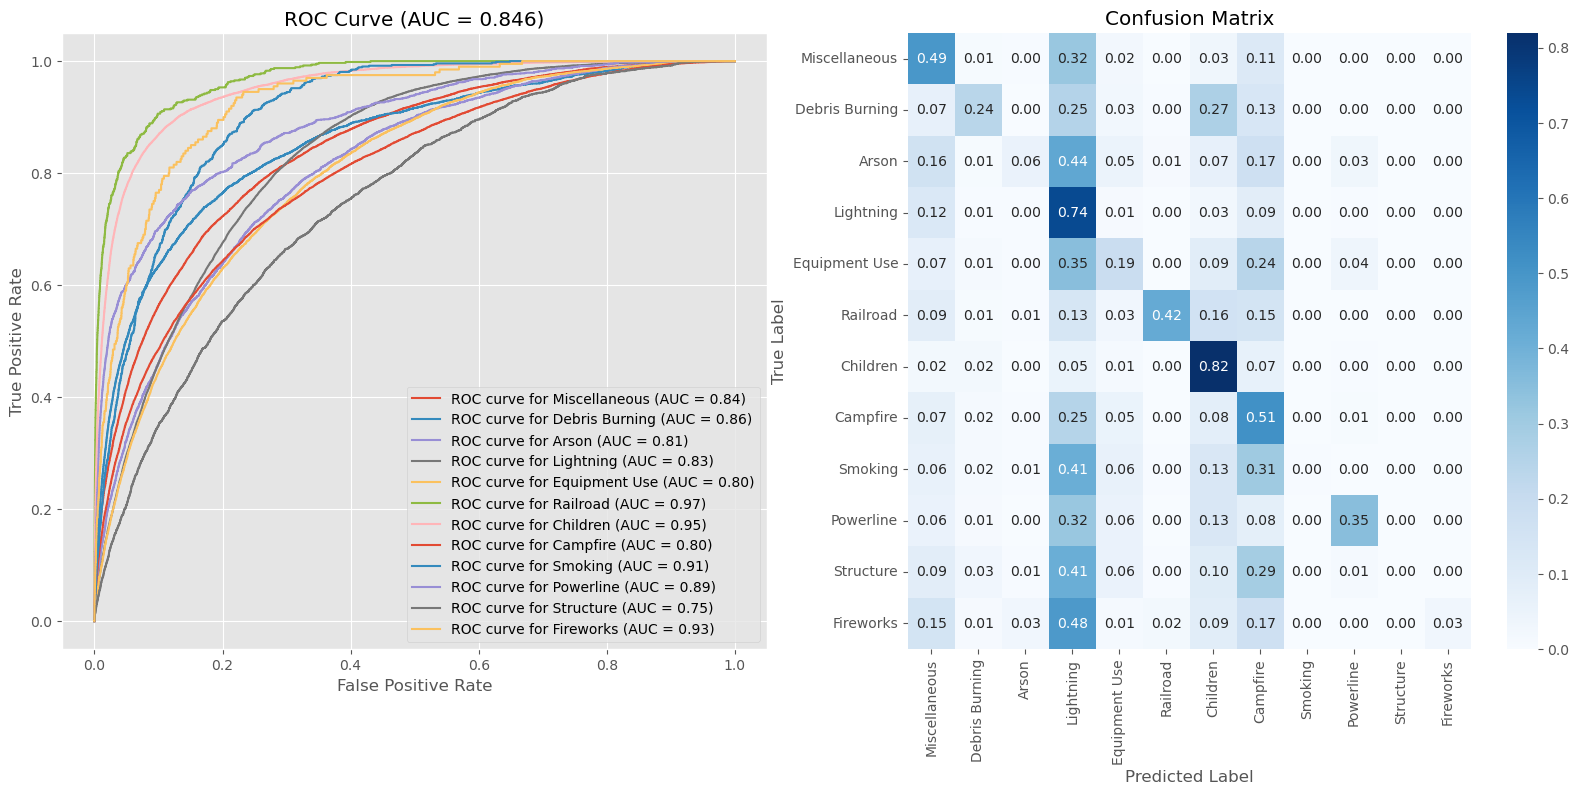

In [96]:
plot_metrics(base_model, X_val, y_val)

### New Model

In [97]:
location_features = [
    "LATITUDE",
    "LONGITUDE",
    "NWCG_REPORTING_UNIT_ID",
    "OWNER_CODE",
    "NEAR_FOREST",
    "OWNER_GROUP",
    "CLIMATE_REGION",
]
datetime_features = [
    "FIRE_YEAR",
    "DISCOVERY_IS_SUMMER",
    "4TH_JULY",
    "FIRE_DUR_DAYS",
    "FIRE_DUR_HOURS",
    "MONTH_SIN",
    "MONTH_COS",
    "DAY_OF_WEEK_SIN",
    "DAY_OF_WEEK_COS",
    "DAY_OF_YEAR_SIN",
    "DAY_OF_YEAR_COS",
]
weather_features = ["AvgTemperature_State_Year_Month", "Temperature_Deviation"]
smoking_features = ["avg_smoking_rate"]
population_features = ["POPULATION"]
description_features = ["FIRE_SIZE_CLASS"]
target = "STAT_CAUSE_DESCR"
cat_features = ["OWNER_CODE", "NWCG_REPORTING_UNIT_ID", "FIRE_SIZE_CLASS", "CLIMATE_REGION"]
features = weather_features + location_features + datetime_features + description_features + smoking_features + population_features

In [98]:
target_le = LabelEncoder()
train[target] = target_le.fit_transform(train[target])
test[target] = target_le.transform(test[target])

In [ ]:
%%script true

def label_encode(train, test, cat_features):
    label_encoders = {}
    for feature in cat_features:
        le = LabelEncoder()
        train[feature] = le.fit_transform(train[feature])
        test[feature] = le.transform(test[feature])
        label_encoders[feature] = le
    return train, test, label_encoders

train, test, label_encoders = label_encode(train, test, cat_features)


In [99]:
# %%script true

def onehot_encode(train, test, cat_features):
    # List to store one-hot encoded feature names
    dummies_features = []

    # One-hot encode categorical features
    for feature in cat_features:
        # Get one-hot encoded columns
        encoded_cols = pd.get_dummies(train[feature], prefix=feature, prefix_sep='_')
        dummies_features.extend(encoded_cols.columns)

        # Concatenate the encoded columns with the original dataframes
        train = pd.concat([train, encoded_cols], axis=1)
        test = pd.concat([test, encoded_cols], axis=1)

        # Drop the original categorical column
        train.drop(feature, axis=1, inplace=True)
        test.drop(feature, axis=1, inplace=True)

    return train, test, dummies_features

# Example usage
train, test, dummies_features = onehot_encode(train, test, cat_features)
features += dummies_features
features = list(set(features) - set(cat_features))

In [108]:
X_train, X_val, y_train, y_val = train_test_split(train[features], train[target], test_size=0.2)
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-mlogloss:2.05948
[1]	validation_0-mlogloss:1.88287
[2]	validation_0-mlogloss:1.76562
[3]	validation_0-mlogloss:1.68411
[4]	validation_0-mlogloss:1.62410
[5]	validation_0-mlogloss:1.57790
[6]	validation_0-mlogloss:1.54379
[7]	validation_0-mlogloss:1.51630
[8]	validation_0-mlogloss:1.49381
[9]	validation_0-mlogloss:1.47618
[10]	validation_0-mlogloss:1.46126
[11]	validation_0-mlogloss:1.44890
[12]	validation_0-mlogloss:1.43604
[13]	validation_0-mlogloss:1.42635
[14]	validation_0-mlogloss:1.41866
[15]	validation_0-mlogloss:1.41078
[16]	validation_0-mlogloss:1.40422
[17]	validation_0-mlogloss:1.39949
[18]	validation_0-mlogloss:1.39446
[19]	validation_0-mlogloss:1.38989
[20]	validation_0-mlogloss:1.38568
[21]	validation_0-mlogloss:1.38279
[22]	validation_0-mlogloss:1.37957
[23]	validation_0-mlogloss:1.37695
[24]	validation_0-mlogloss:1.37385
[25]	validation_0-mlogloss:1.37105
[26]	validation_0-mlogloss:1.36896
[27]	validation_0-mlogloss:1.36705
[28]	validation_0-mlogloss:1.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

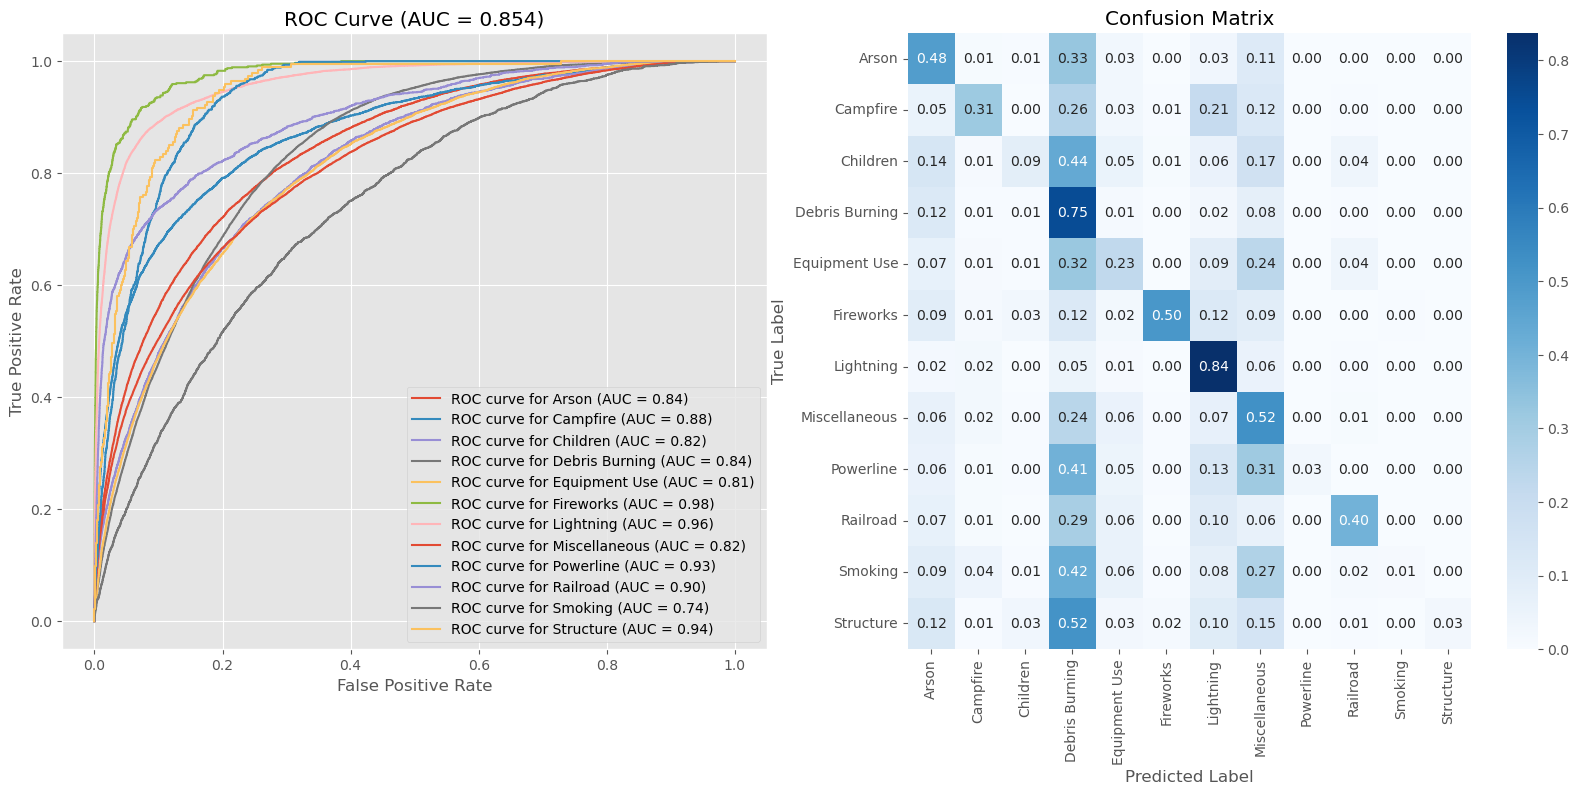

In [109]:
plot_metrics(xgb_model, X_val, y_val, target_le)

In [ ]:
def roc_auc_w_eval(y_pred, dtrain):
    score = roc_auc_score(y_val, y_pred, average="weighted", multi_class="ovr")
    return "score", score

def objective(trial):
    X_train, X_val, y_train, y_val = train_test_split(train[features], train[target], test_size=0.2)
    xgb_model = XGBClassifier(early_stopping_rounds=50)
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    threshold = trial.suggest_float("threshold", 0.0, 0.1)
    feature_selector = SelectFromModel(xgb_model, threshold=threshold, prefit=True)
    X_train = feature_selector.transform(X_train)
    X_val = feature_selector.transform(X_val)
    
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 150, 400),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("lambda", 1e-8, 1.0),
        "reg_alpha": trial.suggest_float("alpha", 1e-8, 1.0),
        "n_jobs": -1,
        "device": "cuda",
    }

    clf = XGBClassifier(**param, early_stopping_rounds=50)
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=roc_auc_w_eval, verbose=False)
    return roc_auc_score(y_val, clf.predict_proba(X_val), average="weighted", multi_class="ovr")


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=1800)

threshold = study.best_params["threshold"]
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("Value: {}".format(trial.value))
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
feature_selector = SelectFromModel(xgb_model, threshold=threshold, prefit=True)
X_train = feature_selector.transform(X_train)
X_val = feature_selector.transform(X_val)
X_test, y_test = feature_selector.transform(test[features]), test[target]

xgb_model_sel = XGBClassifier()
xgb_model_sel.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=roc_auc_w_eval)

In [ ]:
plot_metrics(xgb_model_sel, X_val, y_val, target_le)

In [ ]:
stop

In [110]:
def roc_auc_w_eval(y_pred, dtrain):
    score = roc_auc_score(y_val, y_pred, average="weighted", multi_class="ovr")
    return "score", score


def objective(trial):
    # Define the search space for the threshold
    threshold = trial.suggest_float("threshold", 0.0, 0.1)

    # Select features using the threshold
    feature_selector = SelectFromModel(xgb_model, threshold=threshold, prefit=True)
    X_train_selected = feature_selector.transform(X_train)
    X_val_selected = feature_selector.transform(X_val)

    # Train the final model with the selected features
    clf_sel = XGBClassifier(n_estimators=50)
    clf_sel.fit(X_train_selected, y_train, eval_set=[(X_val_selected, y_val)], eval_metric=roc_auc_w_eval)

    return roc_auc_score(y_val, clf_sel.predict_proba(X_val_selected), average="weighted", multi_class="ovr")


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=300)

threshold = study.best_params["threshold"]
print(f"Best threshold: {threshold}")

[I 2024-05-02 18:06:41,704] A new study created in memory with name: no-name-8b14806a-71f5-484b-add8-6af0ebf57da2
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.23623	validation_0-score:0.64190
[1]	validation_0-mlogloss:2.11412	validation_0-score:0.64252
[2]	validation_0-mlogloss:2.03549	validation_0-score:0.64255
[3]	validation_0-mlogloss:1.98107	validation_0-score:0.64287
[4]	validation_0-mlogloss:1.94196	validation_0-score:0.64289
[5]	validation_0-mlogloss:1.91315	validation_0-score:0.64292
[6]	validation_0-mlogloss:1.89156	validation_0-score:0.64293
[7]	validation_0-mlogloss:1.87516	validation_0-score:0.64298
[8]	validation_0-mlogloss:1.86258	validation_0-score:0.64301
[9]	validation_0-mlogloss:1.85284	validation_0-score:0.64304
[10]	validation_0-mlogloss:1.84526	validation_0-score:0.64314
[11]	validation_0-mlogloss:1.83933	validation_0-score:0.64314
[12]	validation_0-mlogloss:1.83468	validation_0-score:0.64317
[13]	validation_0-mlogloss:1.83102	validation_0-score:0.64321
[14]	validation_0-mlogloss:1.82813	validation_0-score:0.64321
[15]	validation_0-mlogloss:1.82585	validation_0-score:0.64321
[16]	validation_0-

[I 2024-05-02 18:07:00,280] Trial 0 finished with value: 0.6432138604332065 and parameters: {'threshold': 0.04319954288444849}. Best is trial 0 with value: 0.6432138604332065.
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.23623	validation_0-score:0.64190
[1]	validation_0-mlogloss:2.11412	validation_0-score:0.64252
[2]	validation_0-mlogloss:2.03549	validation_0-score:0.64255
[3]	validation_0-mlogloss:1.98107	validation_0-score:0.64287
[4]	validation_0-mlogloss:1.94196	validation_0-score:0.64289
[5]	validation_0-mlogloss:1.91315	validation_0-score:0.64292
[6]	validation_0-mlogloss:1.89156	validation_0-score:0.64293
[7]	validation_0-mlogloss:1.87516	validation_0-score:0.64298
[8]	validation_0-mlogloss:1.86258	validation_0-score:0.64301
[9]	validation_0-mlogloss:1.85284	validation_0-score:0.64304
[10]	validation_0-mlogloss:1.84526	validation_0-score:0.64314
[11]	validation_0-mlogloss:1.83933	validation_0-score:0.64314
[12]	validation_0-mlogloss:1.83468	validation_0-score:0.64317
[13]	validation_0-mlogloss:1.83102	validation_0-score:0.64321
[14]	validation_0-mlogloss:1.82813	validation_0-score:0.64321
[15]	validation_0-mlogloss:1.82585	validation_0-score:0.64321
[16]	validation_0-

[I 2024-05-02 18:07:18,369] Trial 1 finished with value: 0.6432138604332065 and parameters: {'threshold': 0.07988399090353343}. Best is trial 0 with value: 0.6432138604332065.
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.24368	validation_0-score:0.63811
[1]	validation_0-mlogloss:2.12241	validation_0-score:0.63815
[2]	validation_0-mlogloss:2.04442	validation_0-score:0.63815
[3]	validation_0-mlogloss:1.99053	validation_0-score:0.63821
[4]	validation_0-mlogloss:1.95184	validation_0-score:0.63820
[5]	validation_0-mlogloss:1.92337	validation_0-score:0.63820
[6]	validation_0-mlogloss:1.90205	validation_0-score:0.63820
[7]	validation_0-mlogloss:1.88587	validation_0-score:0.63825
[8]	validation_0-mlogloss:1.87347	validation_0-score:0.63827
[9]	validation_0-mlogloss:1.86389	validation_0-score:0.63840
[10]	validation_0-mlogloss:1.85644	validation_0-score:0.63843
[11]	validation_0-mlogloss:1.85062	validation_0-score:0.63843
[12]	validation_0-mlogloss:1.84605	validation_0-score:0.63843
[13]	validation_0-mlogloss:1.84246	validation_0-score:0.63843
[14]	validation_0-mlogloss:1.83963	validation_0-score:0.63843
[15]	validation_0-mlogloss:1.83741	validation_0-score:0.63847
[16]	validation_0-

[I 2024-05-02 18:07:35,861] Trial 2 finished with value: 0.6384817156129146 and parameters: {'threshold': 0.09004391379568548}. Best is trial 0 with value: 0.6432138604332065.
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.18326	validation_0-score:0.69625
[1]	validation_0-mlogloss:2.04862	validation_0-score:0.69690
[2]	validation_0-mlogloss:1.96204	validation_0-score:0.69721
[3]	validation_0-mlogloss:1.90219	validation_0-score:0.69738
[4]	validation_0-mlogloss:1.85922	validation_0-score:0.69751
[5]	validation_0-mlogloss:1.82761	validation_0-score:0.69755
[6]	validation_0-mlogloss:1.80395	validation_0-score:0.69765
[7]	validation_0-mlogloss:1.78599	validation_0-score:0.69766
[8]	validation_0-mlogloss:1.77221	validation_0-score:0.69768
[9]	validation_0-mlogloss:1.76153	validation_0-score:0.69769
[10]	validation_0-mlogloss:1.75319	validation_0-score:0.69770
[11]	validation_0-mlogloss:1.74665	validation_0-score:0.69770
[12]	validation_0-mlogloss:1.74147	validation_0-score:0.69775
[13]	validation_0-mlogloss:1.73737	validation_0-score:0.69779
[14]	validation_0-mlogloss:1.73411	validation_0-score:0.69780
[15]	validation_0-mlogloss:1.73150	validation_0-score:0.69785
[16]	validation_0-

[I 2024-05-02 18:07:56,365] Trial 3 finished with value: 0.6978693267288762 and parameters: {'threshold': 0.02292052117646747}. Best is trial 3 with value: 0.6978693267288762.
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.24368	validation_0-score:0.63811
[1]	validation_0-mlogloss:2.12241	validation_0-score:0.63815
[2]	validation_0-mlogloss:2.04442	validation_0-score:0.63815
[3]	validation_0-mlogloss:1.99053	validation_0-score:0.63821
[4]	validation_0-mlogloss:1.95184	validation_0-score:0.63820
[5]	validation_0-mlogloss:1.92337	validation_0-score:0.63820
[6]	validation_0-mlogloss:1.90205	validation_0-score:0.63820
[7]	validation_0-mlogloss:1.88587	validation_0-score:0.63825
[8]	validation_0-mlogloss:1.87347	validation_0-score:0.63827
[9]	validation_0-mlogloss:1.86389	validation_0-score:0.63840
[10]	validation_0-mlogloss:1.85644	validation_0-score:0.63843
[11]	validation_0-mlogloss:1.85062	validation_0-score:0.63843
[12]	validation_0-mlogloss:1.84605	validation_0-score:0.63843
[13]	validation_0-mlogloss:1.84246	validation_0-score:0.63843
[14]	validation_0-mlogloss:1.83963	validation_0-score:0.63843
[15]	validation_0-mlogloss:1.83741	validation_0-score:0.63847
[16]	validation_0-

[I 2024-05-02 18:08:14,341] Trial 4 finished with value: 0.6384817156129146 and parameters: {'threshold': 0.09019334691058138}. Best is trial 3 with value: 0.6978693267288762.
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.18326	validation_0-score:0.69625
[1]	validation_0-mlogloss:2.04862	validation_0-score:0.69690
[2]	validation_0-mlogloss:1.96204	validation_0-score:0.69721
[3]	validation_0-mlogloss:1.90219	validation_0-score:0.69738
[4]	validation_0-mlogloss:1.85922	validation_0-score:0.69751
[5]	validation_0-mlogloss:1.82761	validation_0-score:0.69755
[6]	validation_0-mlogloss:1.80395	validation_0-score:0.69765
[7]	validation_0-mlogloss:1.78599	validation_0-score:0.69766
[8]	validation_0-mlogloss:1.77221	validation_0-score:0.69768
[9]	validation_0-mlogloss:1.76153	validation_0-score:0.69769
[10]	validation_0-mlogloss:1.75319	validation_0-score:0.69770
[11]	validation_0-mlogloss:1.74665	validation_0-score:0.69770
[12]	validation_0-mlogloss:1.74147	validation_0-score:0.69775
[13]	validation_0-mlogloss:1.73737	validation_0-score:0.69779
[14]	validation_0-mlogloss:1.73411	validation_0-score:0.69780
[15]	validation_0-mlogloss:1.73150	validation_0-score:0.69785
[16]	validation_0-

[I 2024-05-02 18:08:34,389] Trial 5 finished with value: 0.6978693267288762 and parameters: {'threshold': 0.025272785229921324}. Best is trial 3 with value: 0.6978693267288762.
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.05978	validation_0-score:0.78813
[1]	validation_0-mlogloss:1.88293	validation_0-score:0.80080
[2]	validation_0-mlogloss:1.76586	validation_0-score:0.80889
[3]	validation_0-mlogloss:1.68455	validation_0-score:0.81337
[4]	validation_0-mlogloss:1.62235	validation_0-score:0.81722
[5]	validation_0-mlogloss:1.57724	validation_0-score:0.81955
[6]	validation_0-mlogloss:1.54122	validation_0-score:0.82171
[7]	validation_0-mlogloss:1.51369	validation_0-score:0.82329
[8]	validation_0-mlogloss:1.49154	validation_0-score:0.82506
[9]	validation_0-mlogloss:1.47450	validation_0-score:0.82619
[10]	validation_0-mlogloss:1.45964	validation_0-score:0.82740
[11]	validation_0-mlogloss:1.44737	validation_0-score:0.82845
[12]	validation_0-mlogloss:1.43602	validation_0-score:0.82983
[13]	validation_0-mlogloss:1.42687	validation_0-score:0.83076
[14]	validation_0-mlogloss:1.41869	validation_0-score:0.83192
[15]	validation_0-mlogloss:1.41105	validation_0-score:0.83294
[16]	validation_0-

[I 2024-05-02 18:09:01,748] Trial 6 finished with value: 0.8481319910623616 and parameters: {'threshold': 0.002877586504838925}. Best is trial 6 with value: 0.8481319910623616.
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.23623	validation_0-score:0.64190
[1]	validation_0-mlogloss:2.11412	validation_0-score:0.64252
[2]	validation_0-mlogloss:2.03549	validation_0-score:0.64255
[3]	validation_0-mlogloss:1.98107	validation_0-score:0.64287
[4]	validation_0-mlogloss:1.94196	validation_0-score:0.64289
[5]	validation_0-mlogloss:1.91315	validation_0-score:0.64292
[6]	validation_0-mlogloss:1.89156	validation_0-score:0.64293
[7]	validation_0-mlogloss:1.87516	validation_0-score:0.64298
[8]	validation_0-mlogloss:1.86258	validation_0-score:0.64301
[9]	validation_0-mlogloss:1.85284	validation_0-score:0.64304
[10]	validation_0-mlogloss:1.84526	validation_0-score:0.64314
[11]	validation_0-mlogloss:1.83933	validation_0-score:0.64314
[12]	validation_0-mlogloss:1.83468	validation_0-score:0.64317
[13]	validation_0-mlogloss:1.83102	validation_0-score:0.64321
[14]	validation_0-mlogloss:1.82813	validation_0-score:0.64321
[15]	validation_0-mlogloss:1.82585	validation_0-score:0.64321
[16]	validation_0-

[I 2024-05-02 18:09:20,260] Trial 7 finished with value: 0.6432138604332065 and parameters: {'threshold': 0.06063373206681703}. Best is trial 6 with value: 0.8481319910623616.
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.23623	validation_0-score:0.64190
[1]	validation_0-mlogloss:2.11412	validation_0-score:0.64252
[2]	validation_0-mlogloss:2.03549	validation_0-score:0.64255
[3]	validation_0-mlogloss:1.98107	validation_0-score:0.64287
[4]	validation_0-mlogloss:1.94196	validation_0-score:0.64289
[5]	validation_0-mlogloss:1.91315	validation_0-score:0.64292
[6]	validation_0-mlogloss:1.89156	validation_0-score:0.64293
[7]	validation_0-mlogloss:1.87516	validation_0-score:0.64298
[8]	validation_0-mlogloss:1.86258	validation_0-score:0.64301
[9]	validation_0-mlogloss:1.85284	validation_0-score:0.64304
[10]	validation_0-mlogloss:1.84526	validation_0-score:0.64314
[11]	validation_0-mlogloss:1.83933	validation_0-score:0.64314
[12]	validation_0-mlogloss:1.83468	validation_0-score:0.64317
[13]	validation_0-mlogloss:1.83102	validation_0-score:0.64321
[14]	validation_0-mlogloss:1.82813	validation_0-score:0.64321
[15]	validation_0-mlogloss:1.82585	validation_0-score:0.64321
[16]	validation_0-

[I 2024-05-02 18:09:38,943] Trial 8 finished with value: 0.6432138604332065 and parameters: {'threshold': 0.05021567584687982}. Best is trial 6 with value: 0.8481319910623616.
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.24368	validation_0-score:0.63811
[1]	validation_0-mlogloss:2.12241	validation_0-score:0.63815
[2]	validation_0-mlogloss:2.04442	validation_0-score:0.63815
[3]	validation_0-mlogloss:1.99053	validation_0-score:0.63821
[4]	validation_0-mlogloss:1.95184	validation_0-score:0.63820
[5]	validation_0-mlogloss:1.92337	validation_0-score:0.63820
[6]	validation_0-mlogloss:1.90205	validation_0-score:0.63820
[7]	validation_0-mlogloss:1.88587	validation_0-score:0.63825
[8]	validation_0-mlogloss:1.87347	validation_0-score:0.63827
[9]	validation_0-mlogloss:1.86389	validation_0-score:0.63840
[10]	validation_0-mlogloss:1.85644	validation_0-score:0.63843
[11]	validation_0-mlogloss:1.85062	validation_0-score:0.63843
[12]	validation_0-mlogloss:1.84605	validation_0-score:0.63843
[13]	validation_0-mlogloss:1.84246	validation_0-score:0.63843
[14]	validation_0-mlogloss:1.83963	validation_0-score:0.63843
[15]	validation_0-mlogloss:1.83741	validation_0-score:0.63847
[16]	validation_0-

[I 2024-05-02 18:09:56,982] Trial 9 finished with value: 0.6384817156129146 and parameters: {'threshold': 0.09822173129635126}. Best is trial 6 with value: 0.8481319910623616.
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.05948	validation_0-score:0.78802
[1]	validation_0-mlogloss:1.88287	validation_0-score:0.80090
[2]	validation_0-mlogloss:1.76562	validation_0-score:0.80890
[3]	validation_0-mlogloss:1.68411	validation_0-score:0.81342
[4]	validation_0-mlogloss:1.62410	validation_0-score:0.81614
[5]	validation_0-mlogloss:1.57790	validation_0-score:0.81900
[6]	validation_0-mlogloss:1.54379	validation_0-score:0.82070
[7]	validation_0-mlogloss:1.51630	validation_0-score:0.82254
[8]	validation_0-mlogloss:1.49381	validation_0-score:0.82427
[9]	validation_0-mlogloss:1.47618	validation_0-score:0.82565
[10]	validation_0-mlogloss:1.46126	validation_0-score:0.82688
[11]	validation_0-mlogloss:1.44890	validation_0-score:0.82799
[12]	validation_0-mlogloss:1.43604	validation_0-score:0.82979
[13]	validation_0-mlogloss:1.42635	validation_0-score:0.83092
[14]	validation_0-mlogloss:1.41866	validation_0-score:0.83168
[15]	validation_0-mlogloss:1.41078	validation_0-score:0.83293
[16]	validation_0-

[I 2024-05-02 18:10:25,483] Trial 10 finished with value: 0.8473784540000305 and parameters: {'threshold': 0.00041077257275013443}. Best is trial 6 with value: 0.8481319910623616.
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.05950	validation_0-score:0.78802
[1]	validation_0-mlogloss:1.88300	validation_0-score:0.80102
[2]	validation_0-mlogloss:1.76573	validation_0-score:0.80898
[3]	validation_0-mlogloss:1.68420	validation_0-score:0.81345
[4]	validation_0-mlogloss:1.62429	validation_0-score:0.81618
[5]	validation_0-mlogloss:1.57805	validation_0-score:0.81902
[6]	validation_0-mlogloss:1.54325	validation_0-score:0.82090
[7]	validation_0-mlogloss:1.51574	validation_0-score:0.82264
[8]	validation_0-mlogloss:1.49312	validation_0-score:0.82447
[9]	validation_0-mlogloss:1.47454	validation_0-score:0.82594
[10]	validation_0-mlogloss:1.45987	validation_0-score:0.82701
[11]	validation_0-mlogloss:1.44754	validation_0-score:0.82811
[12]	validation_0-mlogloss:1.43723	validation_0-score:0.82922
[13]	validation_0-mlogloss:1.42611	validation_0-score:0.83083
[14]	validation_0-mlogloss:1.41788	validation_0-score:0.83187
[15]	validation_0-mlogloss:1.41098	validation_0-score:0.83266
[16]	validation_0-

[I 2024-05-02 18:10:53,315] Trial 11 finished with value: 0.8475508368699884 and parameters: {'threshold': 0.002807110876842682}. Best is trial 6 with value: 0.8481319910623616.
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.05948	validation_0-score:0.78802
[1]	validation_0-mlogloss:1.88287	validation_0-score:0.80090
[2]	validation_0-mlogloss:1.76562	validation_0-score:0.80890
[3]	validation_0-mlogloss:1.68411	validation_0-score:0.81342
[4]	validation_0-mlogloss:1.62410	validation_0-score:0.81614
[5]	validation_0-mlogloss:1.57790	validation_0-score:0.81900
[6]	validation_0-mlogloss:1.54379	validation_0-score:0.82070
[7]	validation_0-mlogloss:1.51630	validation_0-score:0.82254
[8]	validation_0-mlogloss:1.49381	validation_0-score:0.82427
[9]	validation_0-mlogloss:1.47618	validation_0-score:0.82565
[10]	validation_0-mlogloss:1.46126	validation_0-score:0.82688
[11]	validation_0-mlogloss:1.44890	validation_0-score:0.82799
[12]	validation_0-mlogloss:1.43604	validation_0-score:0.82979
[13]	validation_0-mlogloss:1.42635	validation_0-score:0.83092
[14]	validation_0-mlogloss:1.41866	validation_0-score:0.83168
[15]	validation_0-mlogloss:1.41078	validation_0-score:0.83293
[16]	validation_0-

[I 2024-05-02 18:11:23,016] Trial 12 finished with value: 0.8473784540000305 and parameters: {'threshold': 0.0002912247637747792}. Best is trial 6 with value: 0.8481319910623616.
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.16068	validation_0-score:0.72442
[1]	validation_0-mlogloss:2.02073	validation_0-score:0.72564
[2]	validation_0-mlogloss:1.93130	validation_0-score:0.72616
[3]	validation_0-mlogloss:1.86954	validation_0-score:0.72667
[4]	validation_0-mlogloss:1.82534	validation_0-score:0.72706
[5]	validation_0-mlogloss:1.79293	validation_0-score:0.72738
[6]	validation_0-mlogloss:1.76863	validation_0-score:0.72765
[7]	validation_0-mlogloss:1.75020	validation_0-score:0.72777
[8]	validation_0-mlogloss:1.73595	validation_0-score:0.72788
[9]	validation_0-mlogloss:1.72491	validation_0-score:0.72791
[10]	validation_0-mlogloss:1.71632	validation_0-score:0.72805
[11]	validation_0-mlogloss:1.70952	validation_0-score:0.72813
[12]	validation_0-mlogloss:1.70408	validation_0-score:0.72817
[13]	validation_0-mlogloss:1.69980	validation_0-score:0.72820
[14]	validation_0-mlogloss:1.69638	validation_0-score:0.72824
[15]	validation_0-mlogloss:1.69361	validation_0-score:0.72823
[16]	validation_0-

[I 2024-05-02 18:11:44,438] Trial 13 finished with value: 0.7283464182979895 and parameters: {'threshold': 0.018807072465648143}. Best is trial 6 with value: 0.8481319910623616.


Best threshold: 0.002877586504838925


In [111]:
feature_selector = SelectFromModel(xgb_model, threshold=threshold, prefit=True)
X_train = feature_selector.transform(X_train)
X_val = feature_selector.transform(X_val)
X_test, y_test = feature_selector.transform(test[features]), test[target]

xgb_model_sel = XGBClassifier()
xgb_model_sel.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=roc_auc_w_eval)

/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.05978	validation_0-score:0.78813
[1]	validation_0-mlogloss:1.88293	validation_0-score:0.80080
[2]	validation_0-mlogloss:1.76586	validation_0-score:0.80889
[3]	validation_0-mlogloss:1.68455	validation_0-score:0.81337
[4]	validation_0-mlogloss:1.62235	validation_0-score:0.81722
[5]	validation_0-mlogloss:1.57724	validation_0-score:0.81955
[6]	validation_0-mlogloss:1.54122	validation_0-score:0.82171
[7]	validation_0-mlogloss:1.51369	validation_0-score:0.82329
[8]	validation_0-mlogloss:1.49154	validation_0-score:0.82506
[9]	validation_0-mlogloss:1.47450	validation_0-score:0.82619
[10]	validation_0-mlogloss:1.45964	validation_0-score:0.82740
[11]	validation_0-mlogloss:1.44737	validation_0-score:0.82845
[12]	validation_0-mlogloss:1.43602	validation_0-score:0.82983
[13]	validation_0-mlogloss:1.42687	validation_0-score:0.83076
[14]	validation_0-mlogloss:1.41869	validation_0-score:0.83192
[15]	validation_0-mlogloss:1.41105	validation_0-score:0.83294
[16]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

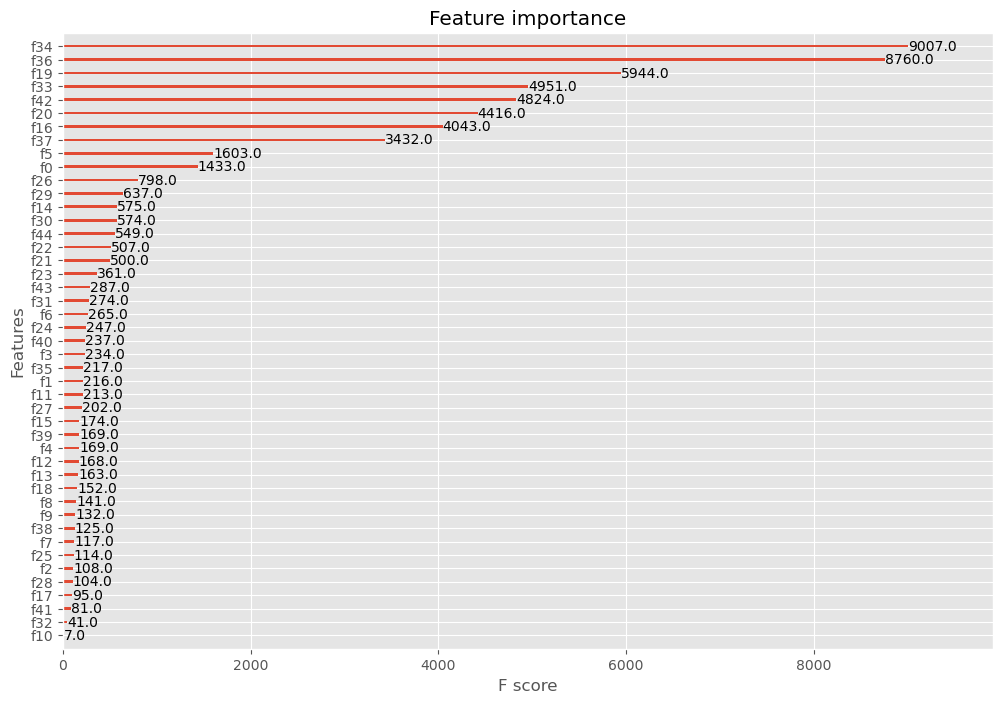

In [112]:
plot_importance(xgb_model_sel)

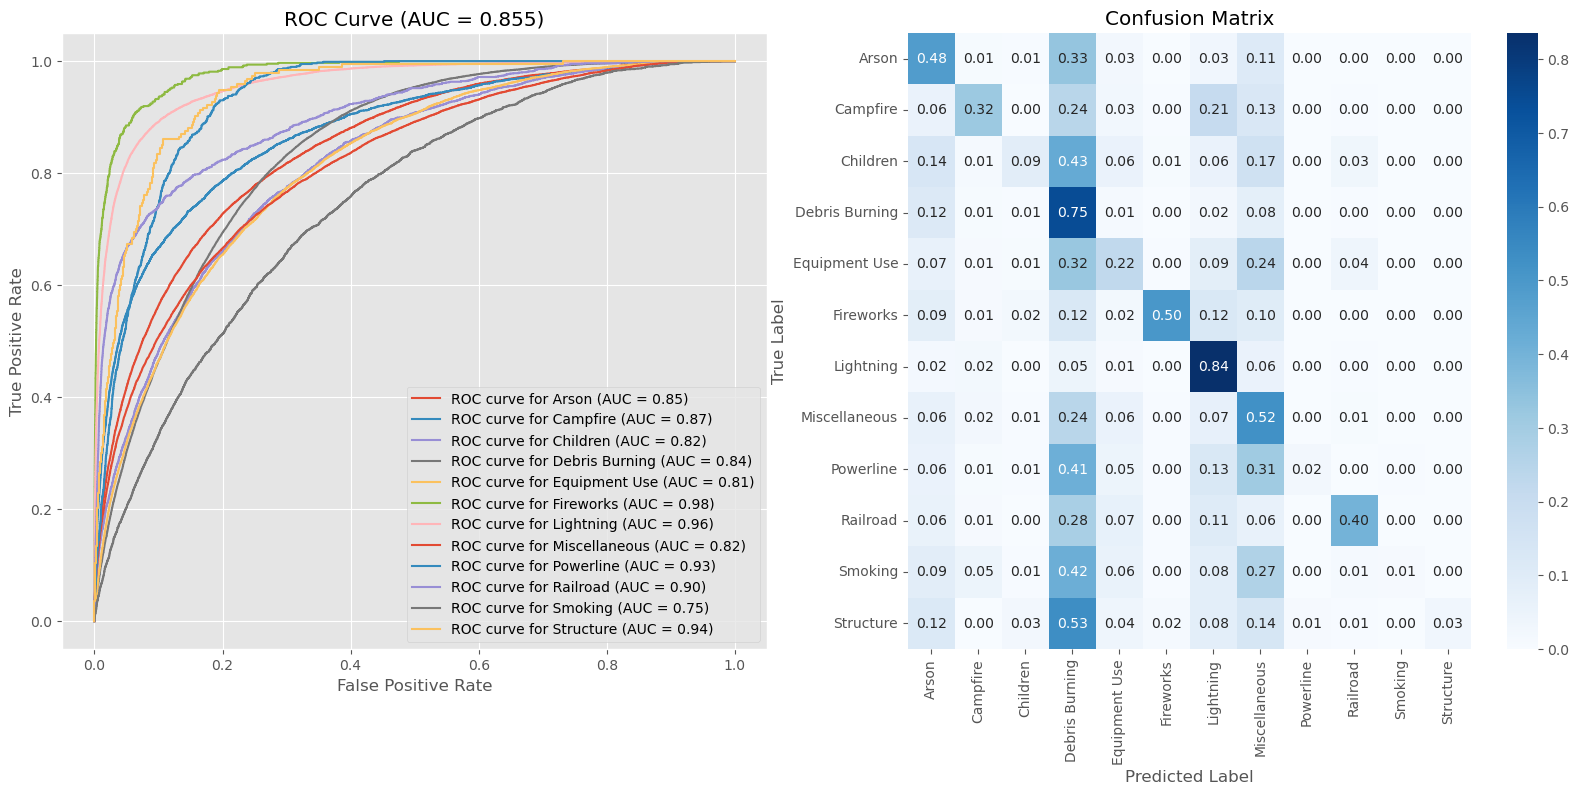

In [113]:
plot_metrics(xgb_model_sel, X_val, y_val, target_le)

In [115]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 150, 400),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("lambda", 1e-8, 1.0),
        "reg_alpha": trial.suggest_float("alpha", 1e-8, 1.0),
        "n_jobs": -1,
    }

    clf = XGBClassifier(**param, early_stopping_rounds=20)
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=roc_auc_w_eval, verbose=False)
    return roc_auc_score(y_val, clf.predict_proba(X_val), average="weighted", multi_class="ovr")


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=900)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("Value: {}".format(trial.value))
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-05-02 18:21:09,179] A new study created in memory with name: no-name-6a374b6e-31e0-4244-a834-90b07092427a
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-05-02 18:21:23,715] Trial 0 finished with value: 0.7999713156698374 and parameters: {'n_estimators': 362, 'learning_rate': 0.149747848048953, 'max_depth': 8, 'colsample_bytree': 0.7769413553836151, 'subsample': 0.8359657914071859, 'min_child_weight': 0.016218743528403357, 'lambda': 0.023162927988901443, 'alpha': 0.07459789343793116}. Best is trial 0 with value: 0.7999713156698374.
/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_

Number of finished trials:  17
Best trial:
Value: 0.8125827738152878
Params: 
    n_estimators: 276
    learning_rate: 0.2525957876094478
    max_depth: 10
    colsample_bytree: 0.8652800276745577
    subsample: 0.8828911573154369
    min_child_weight: 4.807698651927952
    lambda: 0.6367646605521637
    alpha: 0.4488511791900569


In [144]:
trial.params["n_estimators"] = 100

In [145]:
xgb_model_opt = XGBClassifier(**trial.params)
xgb_model_opt.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=roc_auc_w_eval)

/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.07141	validation_0-score:0.81258
[1]	validation_0-mlogloss:1.87964	validation_0-score:0.82797
[2]	validation_0-mlogloss:1.75453	validation_0-score:0.83369
[3]	validation_0-mlogloss:1.66661	validation_0-score:0.83630
[4]	validation_0-mlogloss:1.59802	validation_0-score:0.83910
[5]	validation_0-mlogloss:1.54516	validation_0-score:0.84110
[6]	validation_0-mlogloss:1.50494	validation_0-score:0.84232
[7]	validation_0-mlogloss:1.47087	validation_0-score:0.84414
[8]	validation_0-mlogloss:1.44370	validation_0-score:0.84547
[9]	validation_0-mlogloss:1.42163	validation_0-score:0.84663
[10]	validation_0-mlogloss:1.40379	validation_0-score:0.84754
[11]	validation_0-mlogloss:1.38834	validation_0-score:0.84852
[12]	validation_0-mlogloss:1.37640	validation_0-score:0.84910
[13]	validation_0-mlogloss:1.36653	validation_0-score:0.84957
[14]	validation_0-mlogloss:1.35751	validation_0-score:0.85024
[15]	validation_0-mlogloss:1.34948	validation_0-score:0.85092
[16]	validation_0-

XGBClassifier(alpha=0.4488511791900569, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8652800276745577, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.6367646605521637,
              learning_rate=0.2525957876094478, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=4.807698651927952, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, ...)

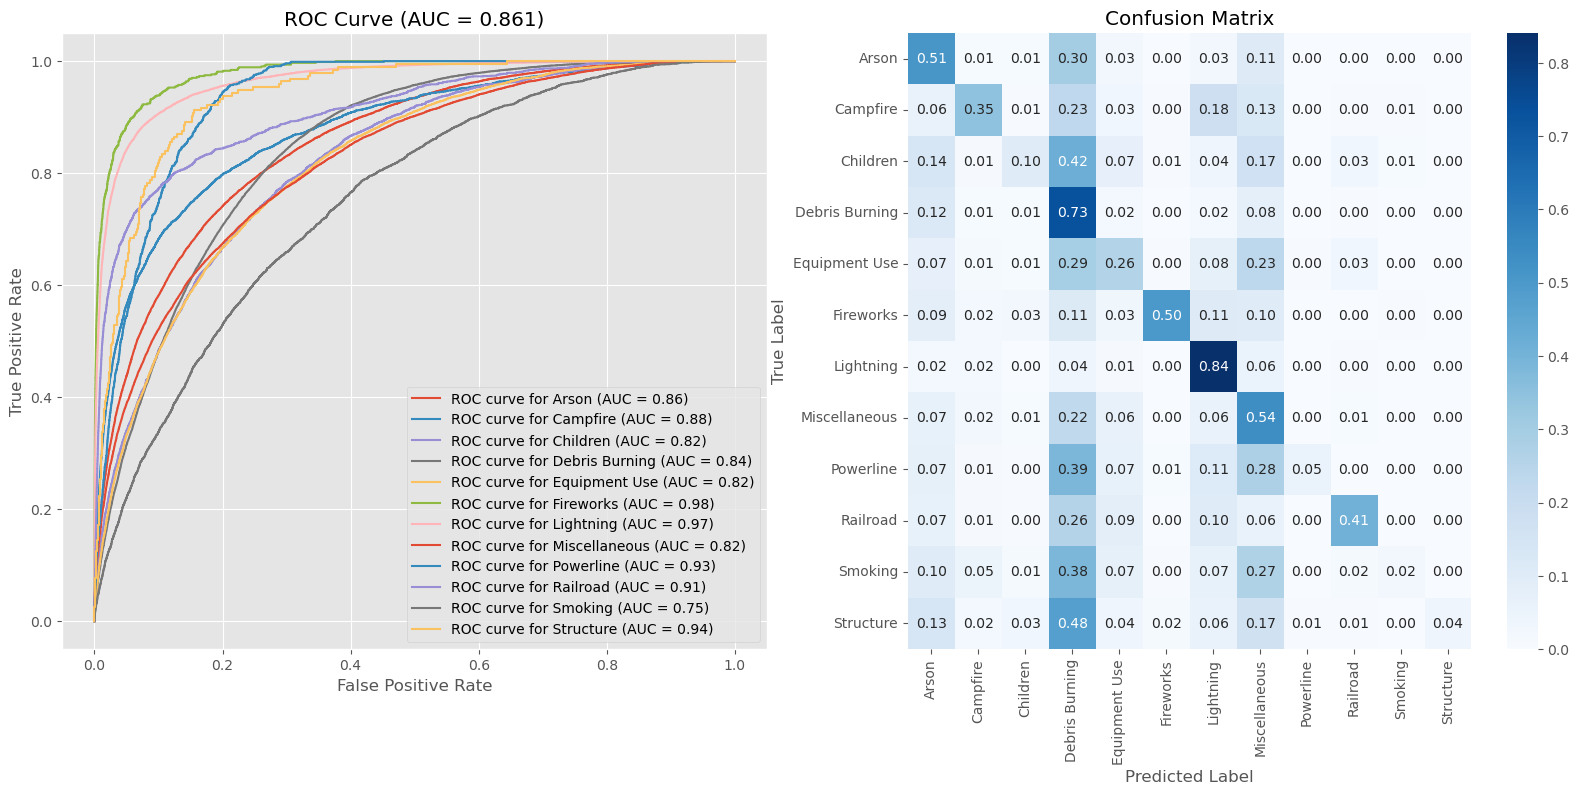

In [146]:
plot_metrics(xgb_model_opt, X_val, y_val, target_le)

In [135]:
X_test, y_test = feature_selector.transform(test[features]), test[target]


/opt/homebrew/anaconda3/envs/datalab/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


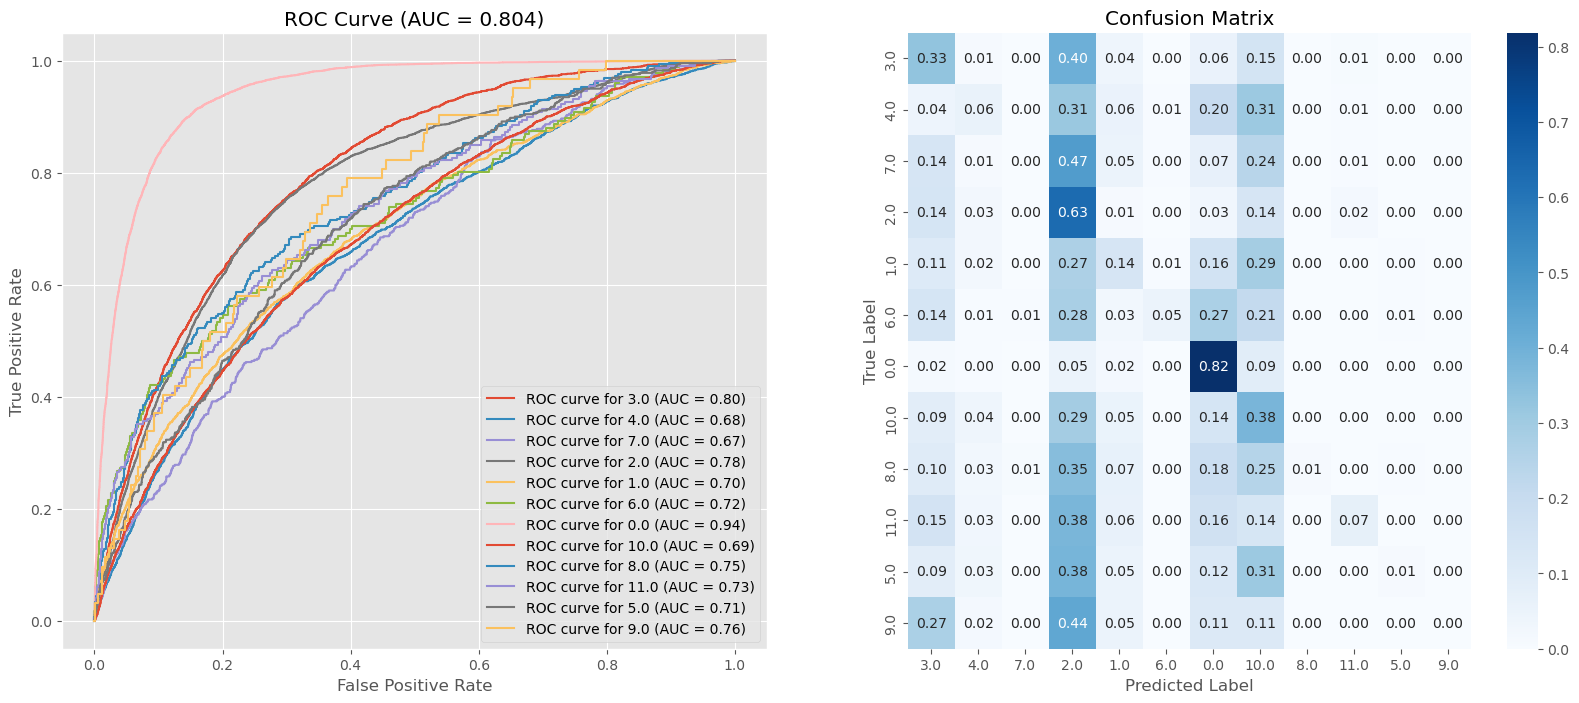

In [147]:
plot_metrics(xgb_model_opt, X_test, y_test)

In [138]:
plot_metrics(xgb_model_opt, X_test, y_test, target_le)

IndexError: arrays used as indices must be of integer (or boolean) type